In [150]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from lifelines import CoxPHFitter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv("../data/intermediate/aggregated.csv")

In [3]:
df.head(3)

,gov_id,country_name,country_region,country_continent,gov_leader,regime_is_democracy,regime_type,gov_start,gov_duration,gov_observed_regular_end,...,sum_crisis_systemic,sum_default_domestic_debt,sum_default_sovereign_debt_tp2,sum_crisis_currency,last_ref_inflation,pond_crisis_banking,pond_crisis_systemic,pond_default_domestic_debt,pond_default_sovereign_debt_tp2,pond_crisis_currency
0,AHMED BEN BELLA,ALGERIA,Northern Africa,Africa,AHMED BEN BELLA,False,Civilian Dict,1962,3,True,...,0,0,0,0,NaN,0.000000,0.000000,0.0,0.000000,0.000000
1,HOUARI BOUMEDIENNE,ALGERIA,Northern Africa,Africa,HOUARI BOUMEDIENNE,False,Military Dict,1965,13,False,...,0,0,0,0,11.450379,0.000000,0.000000,0.0,0.000000,0.000000
2,BENJEDID CHADLI,ALGERIA,Northern Africa,Africa,BENJEDID CHADLI,False,Military Dict,1979,13,True,...,2,0,1,4,25.900000,0.274725,0.274725,0.0,0.142857,0.064485


### Construindo pipeline

Vamos realizar as seguintes transformações no dado:
1. Aplicar OneHotEncoding nas colunas categóricas
3. Aplicar KNN Inputer para preencher valores faltantes em `last_ref_inflation`
4. Aplicar StandardScaler para normalizar valores em `last_ref_inflation`

In [113]:
df.columns

Index(['gov_id', 'country_name', 'country_region', 'country_continent',
       'gov_leader', 'regime_is_democracy', 'regime_type', 'gov_start',
       'gov_duration', 'gov_observed_regular_end', 'gov_observed_death',
       'sum_crisis_banking', 'sum_crisis_systemic',
       'sum_default_domestic_debt', 'sum_default_sovereign_debt_tp2',
       'sum_crisis_currency', 'last_ref_inflation', 'pond_crisis_banking',
       'pond_crisis_systemic', 'pond_default_domestic_debt',
       'pond_default_sovereign_debt_tp2', 'pond_crisis_currency'],
      dtype='object')

In [4]:
cols_to_use = [
        "country_region", "regime_type", 'sum_crisis_banking',
       'sum_crisis_systemic', 'sum_default_domestic_debt',
       'sum_default_sovereign_debt_tp2', 'sum_crisis_currency',
       'last_ref_inflation', 'pond_crisis_banking', 'pond_crisis_systemic',
       'pond_default_domestic_debt', 'pond_default_sovereign_debt_tp2',
       'pond_crisis_currency', 'gov_observed_death', 'gov_duration'
]

In [158]:
def eval_model(df, cols_to_use):

    # SPLITTING DATA
    cols_to_use = cols_to_use + ['gov_observed_death', 'gov_duration']
    cols_to_encode = [col for col in df.columns[df.dtypes == object] if col in cols_to_use]
    X_train, X_test = train_test_split(df[cols_to_use])

    # PREPARING DATA
    transformations = []

    if "last_ref_inflation" in cols_to_use:
        num_mis_pipe = Pipeline([
            ("imputer", KNNImputer()),
            ("scaler", StandardScaler())
        ])
        transformations.append(
            ("imp_disc", num_mis_pipe, ["last_ref_inflation"])
        )
    transformations.append(
        ("encoder", OneHotEncoder(drop="first"), cols_to_encode)
    )

    preprocesser = ColumnTransformer(transformations, remainder="passthrough")

    try:
        X_train = preprocesser.fit_transform(X_train)
        X_test = preprocesser.fit_transform(X_test)
        if not isinstance(X_train, np.ndarray): # IN CASE OF SPARSE MATRIX
            X_train = X_train.toarray()
            X_test = X_test.toarray()

        X_train = pd.DataFrame(
            X_train, 
            columns=preprocesser.get_feature_names_out()
        )
        X_test = pd.DataFrame(
            X_test, 
            columns=preprocesser.get_feature_names_out()
        )

        # EVALUATING MODEL
        cph = CoxPHFitter()
        cph.fit(X_train, event_col="remainder__gov_observed_death", duration_col="remainder__gov_duration")

        return cols_to_use, cph, cph.score(X_test, scoring_method="concordance_index")
    except ValueError:
        return None

In [68]:
combinations_cols = [
    x for x in df.columns 
    if x not in ['gov_id', 'gov_leader', 'country_name', 'gov_start', 'gov_duration', 'gov_observed_regular_end', 'gov_observed_death']
]

combinations_cols = (
    [[x] for x in combinations_cols if not x.startswith("sum_") and not x.startswith("pond_")] + 
    [[x for x in combinations_cols if x.startswith("sum_")]] +
    [[x for x in combinations_cols if x.startswith("pond_")]]
)

In [41]:
from itertools import chain, combinations

In [131]:
generated_combinations = []

def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(3, len(ss) + 1)))

for subset in all_subsets(combinations_cols):
    generated_combinations.append(subset)

In [132]:
generated_combinations = [sum(comb, []) for comb in generated_combinations]

In [139]:
generated_combinations = [x for x in generated_combinations if not ("country_region" in x and "country_continent" in x)]
generated_combinations = [x for x in generated_combinations if not ("regime_is_democracy" in x and "regime_type" in x)]

In [ ]:
evaluated_models = [eval_model(df, comb) for comb in generated_combinations]

In [174]:
evaluated_models = [x for x in evaluated_models if x is not None]

In [175]:
evaluated_models.sort(reverse=True)

In [178]:
choosed_model = evaluated_models[0]

In [181]:
choosed_model[1].print_summary()

/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 690 total observations, 48 right-censored observations>
             duration col = 'remainder__gov_duration'
                event col = 'remainder__gov_observed_death'
      baseline estimation = breslow
   number of observations = 690
number of events observed = 642
   partial log-likelihood = -3342.98
         time fit was run = 2022-06-03 21:36:38 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                          
encoder__regime_type_Military Dict           0.32       1.38       0.17            -0.01             0.66                 0.99                 1.93
encoder__regime_type_Mixed Dem               0.68       1.97       0.18             0.33             1.03                 1.39                 2.79
encoder__regime_type_Monarchy               -2.38       0.09       1.05            -4.44            -0.32                 0.01                 0.73
encoder__regime_type_Parliamentary Dem       0.63       1.87       0.15             0.33             0.92                 1.40                 2.51
encoder__regime_type_Presidential Dem        0.53       1.70       0.16             0.22             0.84                 1.24                 2.31
remainder__sum_crisis_banking               -0.56       0.57       0.10            -0.76            -0.37                 0.47                 0.69
remainder__sum_crisis_systemic               0.41       1.51       0.11             0.19             0.64                 1.21                 1.89
remainder__sum_default_domestic_debt        -0.05       0.95       0.07            -0.18             0.09                 0.83                 1.09
remainder__sum_default_sovereign_debt_tp2   -0.17       0.84       0.05            -0.26            -0.08                 0.77                 0.92
remainder__sum_crisis_currency              -0.27       0.76       0.04            -0.34            -0.20                 0.71                 0.82
remainder__pond_crisis_banking               2.02       7.54       0.30             1.44             2.60                 4.20                13.53
remainder__pond_crisis_systemic             -1.35       0.26       0.40            -2.14            -0.56                 0.12                 0.57
remainder__pond_default_domestic_debt        0.24       1.27       0.30            -0.35             0.83                 0.71                 2.30
remainder__pond_default_sovereign_debt_tp2   0.92       2.52       0.23             0.46             1.38                 1.59                 3.99
remainder__pond_crisis_currency              2.27       9.66       0.22             1.84             2.70                 6.28                14.85

                                             cmp to     z      p   -log2(p)
covariate                                                                  
encoder__regime_type_Military Dict             0.00  1.90   0.06       4.11
encoder__regime_type_Mixed Dem                 0.00  3.80 <0.005      12.78
encoder__regime_type_Monarchy                  0.00 -2.26   0.02       5.41
encoder__regime_type_Parliamentary Dem         0.00  4.18 <0.005      15.08
encoder__regime_type_Presidential Dem          0.00  3.33 <0.005      10.17
remainder__sum_crisis_banking                  0.00 -5.75 <0.005      26.73
remainder__sum_crisis_systemic                 0.00  3.66 <0.005      11.96
remainder__sum_default_domestic_debt           0.00 -0.70   0.48       1.06
remainder__sum_default_sovereign_debt_tp2      0.00 -3.66 <0.005      11.95
remainder__sum_crisis_currency                 0.00 -7.32 <0.005      41.93
remainder__pond_crisis_banking                 0.00  6.78 <0.005      36.24
remainder__pond_crisis_systemic                0.00 -3.35 <0.005      10.30
remainder__pond_def

<AxesSubplot:xlabel='log(HR) (95% CI)'>

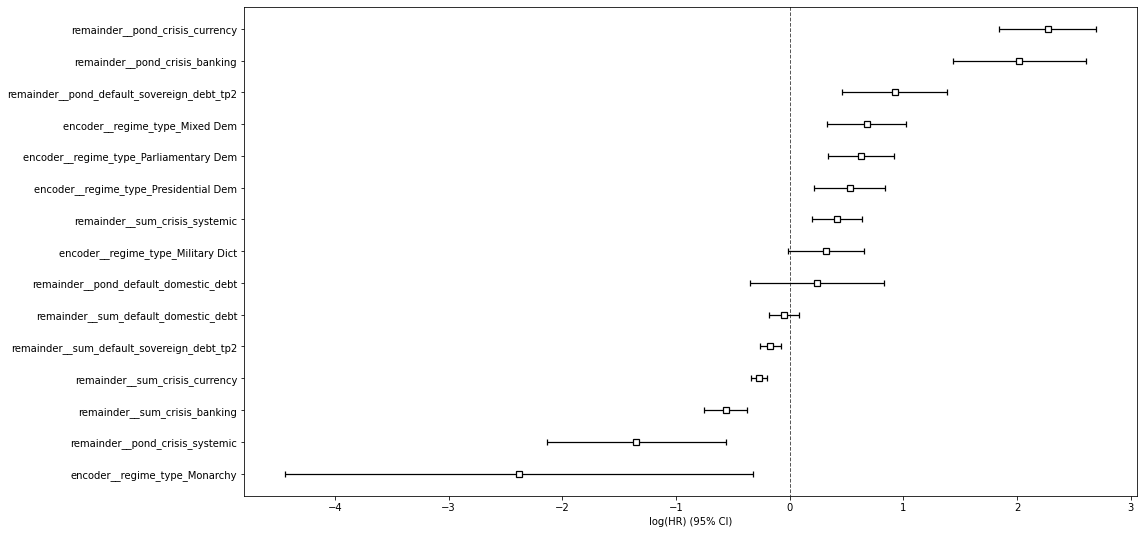

In [182]:
fig, ax = plt.subplots(figsize=(16, 9))

choosed_model[1].plot()